# HW10

### Author: Joseph Wong

Data was ethically scraped from https://www.billboard.com/artist/taylor-swift/chart-history/hsi/. The data focuses on songs released by Taylor Swift that have charted on the Billboard Hot 100, which ranks by streaming activity, radio airplay audience impressions, and sales data (performed by Luminate).

## Import Packages

In [1]:
# Some basic package imports
import os
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.defaule = 'colab'
import seaborn as sns

# Datetime packages
from datetime import datetime

In [2]:
import requests
from bs4 import BeautifulSoup

# For dynamic sites using chrome
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import time

## Webscrape the Data

In [3]:
URL = "https://www.billboard.com/artist/taylor-swift/chart-history/hsi/"
page = requests.get(URL)
soup = BeautifulSoup(page.text, "html.parser")
row = soup.find_all(class_="o-chart-results-list-row")

songs = []
for r in row:
    song = r.find("h3", class_="c-title")
    artist = r.find("span", class_="artist-chart-row-artist")
    peak_pos = r.find("span", class_="artist-chart-row-peak-pos")
    peak_wk = r.find("span", class_="artist-chart-row-peak-week")
    wks_on_chart = r.find("span", class_="artist-chart-row-week-on-chart")
    
    # dates have same element and class so use find_all then choose from array
    dates = r.find_all("a", class_="c-label__link")
    debut_date = dates[0]
    peak_date = dates[1]
    
    songs.append({'Song':song.text.strip(),
               'Artist':artist.text.strip(),
               'Debut Date':debut_date.text.strip(),
               'Peak Position':peak_pos.text.strip(),
               # peak week is 12 when the song did not peak at number 1
               'Weeks at Number 1':0 if peak_wk.text.split()[0]=="12" else peak_wk.text.split()[0],
               'Peak Date':peak_date.text.strip(),
               'Weeks on Chart':wks_on_chart.text.strip()})

df = pd.DataFrame(songs)
df

,Song,Artist,Debut Date,Peak Position,Weeks at Number 1,Peak Date,Weeks on Chart
0,Anti-Hero,Taylor Swift,11/05/22,1,8,11/05/22,53
1,Blank Space,Taylor Swift,11/15/14,1,7,11/29/14,38
2,Cruel Summer,Taylor Swift,9/07/19,1,4,10/28/23,54
3,Shake It Off,Taylor Swift,9/06/14,1,4,9/06/14,50
4,Look What You Made Me Do,Taylor Swift,9/09/17,1,3,9/16/17,20
...,...,...,...,...,...,...,...
271,Starlight (Taylor's Version),Taylor Swift,11/27/21,90,0,11/27/21,1
272,Stay Stay Stay,Taylor Swift,11/10/12,91,0,11/10/12,1
273,It's Nice To Have A Friend,Taylor Swift,9/07/19,92,0,9/07/19,1
274,The Way I Loved You (Taylor's Version),Taylor Swift,4/24/21,94,0,4/24/21,1


## Data Basics and Preparation

### Variables

In [4]:
df.shape

(276, 7)

There are 276 observations and 7 variables.

In [5]:
df.dtypes

Song                 object
Artist               object
Debut Date           object
Peak Position        object
Weeks at Number 1    object
Peak Date            object
Weeks on Chart       object
dtype: object

Each column is set to be an object after being scraped. So, we will change the columns to contain the proper data types.

In [6]:
df['Peak Position'] = df['Peak Position'].astype(int)
df['Weeks at Number 1'] = df['Weeks at Number 1'].astype(int)
df['Weeks on Chart'] = df['Weeks on Chart'].astype(int)
# dates should be datetime objects
df['Debut Date'] = pd.to_datetime(df['Debut Date'],format="%m/%d/%y")
df['Peak Date'] = pd.to_datetime(df['Peak Date'],format="%m/%d/%y")

In [7]:
df.dtypes

Song                         object
Artist                       object
Debut Date           datetime64[ns]
Peak Position                 int64
Weeks at Number 1             int64
Peak Date            datetime64[ns]
Weeks on Chart                int64
dtype: object

**Variables**
- *Song (object)*: song name
- *Artist (object)*: artist name(s)
- *Debut Date (datetime)*: date of song debut
- *Peak Position (int)*: highest position
- *Weeks at Number 1 (int)*: weeks at number 1
- *Peak Date (datetime)*: date of reaching peak position
- *Weeks on Chart (int)*: total number of weeks on the chart

In [8]:
df.describe()

,Debut Date,Peak Position,Weeks at Number 1,Peak Date,Weeks on Chart
count,276,276.000000,276.000000,276,276.000000
mean,2019-08-21 02:00:00,33.333333,0.134058,2019-09-16 00:05:13.043478272,6.800725
min,2006-09-23 00:00:00,1.000000,0.000000,2007-01-13 00:00:00,1.000000
25%,2016-07-21 06:00:00,10.750000,0.000000,2016-12-17 00:00:00,1.000000
50%,2021-10-30 00:00:00,28.000000,0.000000,2021-11-27 00:00:00,2.000000
75%,2023-07-22 00:00:00,52.000000,0.000000,2023-07-22 00:00:00,7.000000
max,2025-10-18 00:00:00,94.000000,8.000000,2025-10-18 00:00:00,54.000000
std,NaN,25.891896,0.781699,NaN,10.307639


In [9]:
df['Weeks at Number 1'].value_counts()

Weeks at Number 1
0    263
1      6
4      2
3      2
8      1
7      1
2      1
Name: count, dtype: int64

The range of 'Debut Date' is from 09/23/2006 to 10/18/2025 and the range of 'Peak Date' is from 01/13/2007 to 10/18/2025. The 'Weeks at Number 1' is 0 at its minimum, Q1, median, and Q3 and has a maximum of 8 weeks. This is because there are only 13 songs that hit number 1. The median 'Peak Position' is 28 while the mean is 33.3333.  The 'Weeks on Chart' has a median of 2 and mean of 6.8007. Having a median less than the mean suggests a right skewedenss of the data, which means there may be some large outliers that are pulling the mean away from the median.

### NaNs

In [10]:
df.isna().sum()

Song                 0
Artist               0
Debut Date           0
Peak Position        0
Weeks at Number 1    0
Peak Date            0
Weeks on Chart       0
dtype: int64

There are no NaNs in the dataset.

## Basic Data Exploration

### Distribution of Peak Position

In [11]:
fig = px.histogram(df,
                   x='Peak Position',
                   nbins=20,
                   title="Frequency of Peak Position")
fig.update_layout(xaxis_title="Peak Position",
                 yaxis_title="Frequency")
fig.show()

The graph shows the frequency of the peak positions of songs that made it onto the Billboard Hot 100. The most frequent peak positions are from 1-4, with 35 songs reaching those positions. Only 5 songs peaked at positions 90-94. It appears that the frequency tends to decreases as the peak position increases. This suggests a song that charts is more likely to peak at a high position.

### Distribution of Weeks at Number 1

In [12]:
fig = px.histogram(df,
                   x='Weeks at Number 1',
                   title="Frequency of Weeks at Number 1")
fig.update_layout(xaxis_title="Weeks at Number 1",
                 yaxis_title="Frequency")
fig.show()

The graph shows the frequency of the number weeks at number 1 of songs that made it onto the Billboard Hot 100. The most frequent number of weeks is 0, as many songs did not reach number 1 on the charts.

### Distribution of Weeks on Chart

In [13]:
fig = px.histogram(df,
                   x='Weeks on Chart',
                   nbins=30,
                   title="Frequency of Weeks on Chart")
fig.update_layout(xaxis_title="Weeks on Chart",
                 yaxis_title="Frequency")
fig.show()

The graph shows the frequency of the number of weeks on the Billboard Hot 100. The most frequent number of weeks is 1 (there are no songs in the dataset that have 0 weeks on the chart). The frequency appears to decrease for greater number of weeks on the charts.

## Further Exploration

### Weeks on Chart Over Time

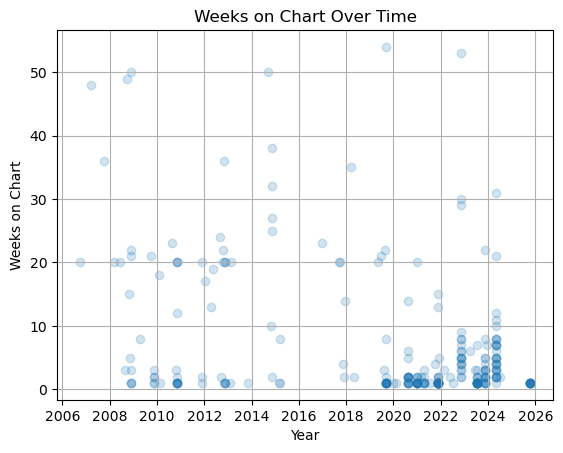

In [14]:
x = df['Debut Date']
y = df['Weeks on Chart']
plt.scatter(x,y,alpha=.2)
plt.grid()
plt.title("Weeks on Chart Over Time")
plt.xlabel("Year")
plt.ylabel("Weeks on Chart")
plt.show()

The graph shows the number of weeks a song is on the Billboard Hot 100 over time. It appears that there is more data 2020 onwards. This suggests more recent releases tend to make the charts compared to older releases. There are songs with high numbers of weeks on the chart across 2006-2025, which suggests a song's lasting popoularity is not necessarily related to when it was released.

### Weeks on Chart for Songs that Peaked at Number 1 Over Time

In [15]:
fig = px.scatter(df[df['Peak Position'] == 1],
                 x='Debut Date',
                 y='Weeks on Chart',
                 hover_data='Song',
                 title="Weeks on Chart for Songs that Peaked at Number 1 Over Time")
fig.update_layout(xaxis_title="Year",
                 yaxis_title="Weeks on Chart",
                 width=1000)
fig.update_traces(marker=dict(size=10))
fig.show()

The graph shows how many weeks each song that peaked at number 1 stayed on the charts across the years. In general, it appears that songs tend to have fewer weeks on the charts as their debut date increases. That is, songs that debuted more recently typically have shorter lives on the charts. It is important to note that the most recent song on the graph was released October 2025, which does not give it much time to stay on the charts.


## How long does it take for a song to reach its peak?

In [16]:
# create col 'Days to Peak' that is peak date - debut date
# divide by pd.Timedelta(days=1) because otherwise stored as 
# cast to be an int
df['Days to Peak'] = (df['Peak Date'] - df['Debut Date']) / pd.Timedelta(days=1)
df['Days to Peak'] = df['Days to Peak'].astype(int)

In [17]:
fig = px.histogram(df,
                   x='Days to Peak',
                   title="Frequency of Days to Peak")
fig.update_layout(xaxis_title="Days to Peak",
                 yaxis_title="Frequency")
fig.show()

In [18]:
df[df['Days to Peak']==df['Days to Peak'].max()]

,Song,Artist,Debut Date,Peak Position,Weeks at Number 1,Peak Date,Weeks on Chart,Days to Peak
2,Cruel Summer,Taylor Swift,2019-09-07,1,4,2023-10-28,54,1512


The graph shows the frequency of how many days from debut it takes for a song to reach its peak on the Billboard Hot 100. The vast majority of songs in the data set take under 50 days to reach their peak. There are 35 songs that took longer than 50 days to reach their peak on the charts. There is an outlier that took 1512 days to reach its peak (Cruel Summer). It was originally released in 2019, but took until 2023 to hit number 1 on the Billboard Hot 100.

## Conclusion

The data set pertains to songs released by Taylor Swift that have charted on the Billboard Hot 100. Out of the 276 songs that have charted, 13 have peaked at number 1. The debut dates of the songs range from 09/23/2006 to 10/18/2025. Songs that charted tend to have higher placements (i.e. closer to number 1) than lower placements. The majority of songs that chart only chart for a few weeks maximum, although there are some exceptions. Additionally, songs with recent debut dates more frequently chart than older releases. However, there are songs that stay on the charts for a high number of weeks regardless of their debut date. Furthermore, there is a potential negative trend for songs that peaked at number 1 between weeks on the chart and debut date. That is older releases that hit number 1 tend to have stayed on the charts longer than newer releases that hit number 1. Finally, most songs peak in under 50 days from their release. But, there a few exceptions. Notably, in 2023 Cruel Summer peaked at number 1 1512 days after its release in 2019. In conclusion, analyzing this data set gives us a better idea of how Taylor Swift's music performs on the charts throughout her career.